# DoomTakeCover-v0

In [85]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/doom.config'])

In [86]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [87]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [88]:
filelist = os.listdir(DATA_DIR)

In [89]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [90]:
obs.shape

(219, 64, 64, 3)

In [91]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [92]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

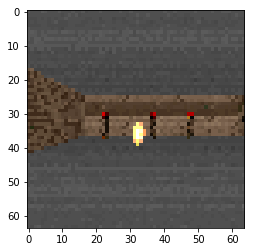

In [93]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [94]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.2649 -1.24    0.3772  0.0588  1.7639 -0.6479  0.7039 -1.2835  0.6836 -0.934  -0.4954 -1.284
 -0.6547 -0.3405 -1.1948  0.4743  0.8505 -0.7026  0.2161 -0.7643 -0.3352  2.186   0.2115  0.1699
 -1.9609  0.7103 -0.0705  0.8561  0.6792  0.2014 -0.754   0.4514  0.268   0.5458 -0.4752 -0.1291
  1.5885  0.4403  0.5682  1.2924  0.9561 -0.7455  0.9365  0.2207 -2.0272  0.1045  0.6906 -0.1029
  0.498   0.3026  0.3893  0.5205  0.3045 -0.2365  1.5718  0.0524 -0.2517 -0.6798 -0.2649  1.1721
  1.1379 -1.5966  0.7288 -0.797 ], shape=(64,), dtype=float32)


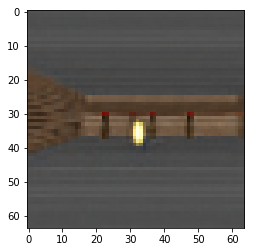

In [95]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

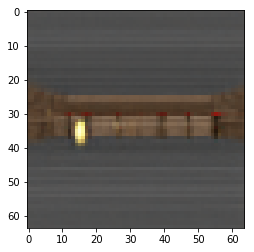

In [96]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Simulate and Store for Animation

In [46]:
def sim(c, env, vae, is_true_env=False, z_size=64):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(1000): # episode length is a thousand
        a = c.get_action(o)
        o, r, _, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
    return decoded_frames, true_frames, r_list, total_r_list

## Acting in dream environment
visualize what the agent sees when acting in the dream environment

In [54]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=True, with_obs=True)
reconstruct_episode, _, dream_r, dream_total_r = sim(c, true_env, vae, is_true_env=False, z_size=args.z_size)
true_env.close()

loading file results/WorldModels/DoomTakeCover-v0/log/DoomTakeCover-v0.cma.16.64.json
making rnn doom environment

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>


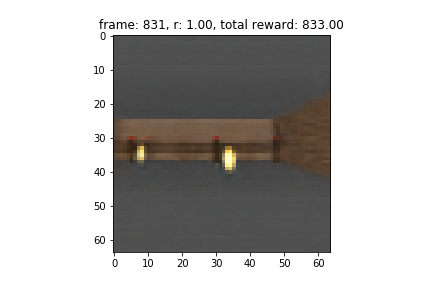

In [40]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, dream_r[frame_index+1], dream_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=1000, blit=True)


## Acting in true environment
visualize what the agent sees when acting in the true environment

In [36]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size)
true_env.close()

loading file results/WorldModels/DoomTakeCover-v0/log/DoomTakeCover-v0.cma.16.64.json
making real doom environment

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>


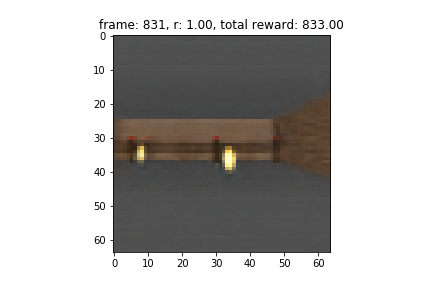

In [40]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=1000, blit=True)


## Return Plot for Controller

In [97]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.64.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))

with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)

eager_data = np.array(eager_data)

FileNotFoundError: [Errno 2] No such file or directory: 'results/WorldModels/DoomTakeCover-v0/log/DoomTakeCover-v0.cma.16.64.eval_hist.json'

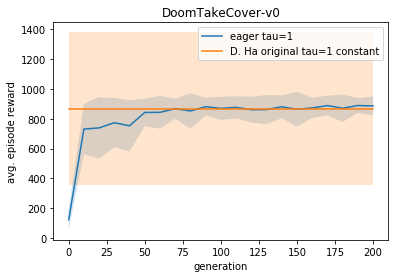

In [98]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_tau_1_ret = np.zeros_like(eager_x) + 868.0
og_tau_1_std = np.zeros_like(eager_x) + 511.0

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(eager_x, og_tau_1_ret)
plt.fill_between(eager_x, og_tau_1_ret-og_tau_1_std, og_tau_1_ret+og_tau_1_std, alpha=0.2)

plt.title('DoomTakeCover-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager tau=1', 'D. Ha original tau=1 constant'])

# CarRacing-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [17]:
filelist = os.listdir(DATA_DIR)

In [18]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [19]:
obs.shape

(1000, 64, 64, 3)

In [20]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [21]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

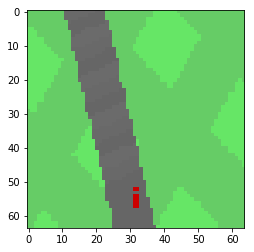

In [22]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [23]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[ 0.5467 -0.1996  1.1636 -0.9279 -0.123   0.3284 -0.2489 -0.1666 -0.7751 -2.1669  0.4378  0.5337
 -1.1857 -1.9297 -0.3461 -0.5546 -0.9321 -0.0906 -0.1672 -0.0957 -1.5155 -0.2353 -0.604  -0.838
 -1.4866 -1.4614  1.2177  0.5176  0.2094 -2.7761  0.4941 -0.2653], shape=(32,), dtype=float32)


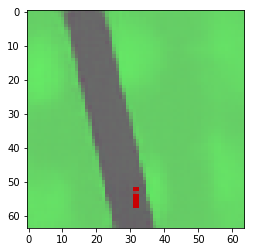

In [24]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

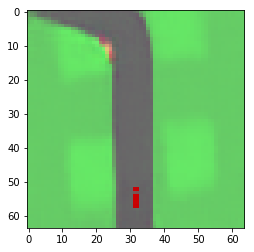

In [45]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [47]:
c = make_controller(args)
c.load_model('results/{}/{}/log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size)
true_env.close()

loading file results/WorldModels/CarRacing-v0/log/CarRacing-v0.cma.16.64.json
makeing real CarRacing environment
Track generation: 1249..1566 -> 317-tiles track


NoSuchDisplayException: Cannot connect to "None"

<IPython.core.display.Javascript object>


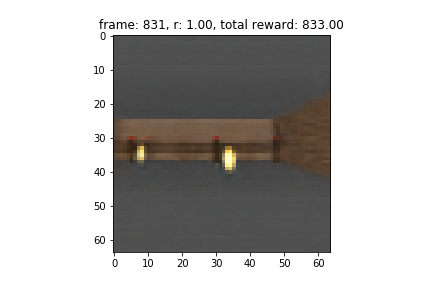

In [40]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=1000, blit=True)


## Return Plot for Controller

In [71]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.64.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

8


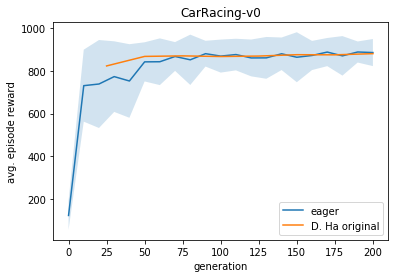

In [81]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original'])